In [1]:
import scanpy as sc
import pandas as pd
import scvi
import numpy as np
import anndata
import os
import re

os.chdir("/Users/piamozdzanowski/Documents/GitHub/PerturbCycleVI")

/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)


### Load Plates

In [2]:
plate7 = sc.read_h5ad('tahoe_data/plate7_DMSO_Dinaciclib_A549_HT-29.h5ad')
plate8 = sc.read_h5ad('tahoe_data/plate8_DMSO_Dinaciclib_A549_HT-29.h5ad')
plate9 = sc.read_h5ad('tahoe_data/plate9_DMSO_Dinaciclib_A549_HT-29.h5ad')

In [3]:
plate10 = sc.read_h5ad('tahoe_data/plate10_Dapagliflozin_A549_HT-29.h5ad')
plate11 = sc.read_h5ad('tahoe_data/plate11_Dapagliflozin_A549_HT-29.h5ad')
plate12 = sc.read_h5ad('tahoe_data/plate12_Dapagliflozin_A549_HT-29.h5ad')

## Dinaciclib

In [73]:
# Merge all plates into a single AnnData object
adata = anndata.concat(
    [plate7, plate8, plate9],
    keys=["plate7", "plate8", "plate9"],
    index_unique=None           # Keeps original cell barcodes
)

# Check initial cell counts per (drugconc, cell_name) group
group_counts = adata.obs.groupby(["drugconc", "cell_name"]).size()
print("Initial cell counts per group:\n", group_counts)

# Determine the minimum number of cells across all groups
min_cells = group_counts.min()
print(f"\nSampling {min_cells} cells per (drugconc, cell_name) group to balance the dataset")

# Subsample the dataset to balance all groups
balanced_idx = (
    adata.obs
    .groupby(["drugconc", "cell_name"], observed=True, group_keys=False)
    .apply(lambda x: x.sample(min_cells, random_state=0))
    .index
)
adata = adata[balanced_idx].copy()

# Confirm the balanced group sizes
balanced_counts = adata.obs.groupby(["drugconc", "cell_name"],observed=True).size()
print("\nBalanced cell counts per group:\n", balanced_counts)

adata.write("tahoe_data/adata_Dinaciclib_balanced.h5ad")


Initial cell counts per group:
 drugconc  cell_name
0.00      A549         10857
          HT-29         8866
0.05      A549           448
          HT-29          546
0.50      A549           923
          HT-29         1207
5.00      A549           269
          HT-29          482
dtype: int64

Sampling 269 cells per (drugconc, cell_name) group to balance the dataset

Balanced cell counts per group:
 drugconc  cell_name
0.00      A549         269
          HT-29        269
0.05      A549         269
          HT-29        269
0.50      A549         269
          HT-29        269
5.00      A549         269
          HT-29        269
dtype: int64


/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_3581/1884003042.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = adata.obs.groupby(["drugconc", "cell_name"]).size()
/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_3581/1884003042.py:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_cells, random_state=0))


## Dapagliflozin

In [4]:
import anndata as ad

# Select control cells (drugconc == 0) from plate9
plate9_control = plate9[plate9.obs["drugconc"] == 0].copy()

# Concatenate datasets: treated plates + control cells
adata = ad.concat(
    [plate10, plate11, plate12, plate9_control],
    keys=["plate10", "plate11", "plate12", "plate9_control"],
    index_unique=None
)

# Count cells per (drugconc, cell_name) group
group_counts = adata.obs.groupby(["drugconc", "cell_name"]).size()
print("Initial cell counts per group:\n", group_counts)

# Determine smallest group size for balanced sampling
min_cells = group_counts.min()
print(f"\nSampling {min_cells} cells per group to balance dataset")

# Subsample each group to equal size
balanced_idx = (
    adata.obs
    .groupby(["drugconc", "cell_name"], observed=True, group_keys=False)
    .apply(lambda x: x.sample(min_cells, random_state=0))
    .index
)
adata = adata[balanced_idx].copy()

# Confirm final balanced group sizes
balanced_counts = adata.obs.groupby(["drugconc", "cell_name"], observed=True).size()
print("\nBalanced cell counts per group:\n", balanced_counts)

/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1577/2519675861.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_counts = adata.obs.groupby(["drugconc", "cell_name"]).size()
/var/folders/k3/mmnc54pj1f990615yjp32jy00000gn/T/ipykernel_1577/2519675861.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min_cells, random_state=0))


Initial cell counts per group:
 drugconc  cell_name
0.00      A549         3578
          HT-29        2755
0.05      A549         2303
          HT-29        2149
0.50      A549         3194
          HT-29        2766
5.00      A549         3498
          HT-29        2758
dtype: int64

Sampling 2149 cells per group to balance dataset

Balanced cell counts per group:
 drugconc  cell_name
0.00      A549         2149
          HT-29        2149
0.05      A549         2149
          HT-29        2149
0.50      A549         2149
          HT-29        2149
5.00      A549         2149
          HT-29        2149
dtype: int64


In [39]:
adata

AnnData object with n_obs × n_vars = 17192 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc'

### ID Conversion

In [43]:
# Get all gene symbols in adata (i.e., those that do NOT start with 'ENSG')
symbols_in_adata = [g for g in adata.var_names if not g.startswith("ENSG")]

# Make a set for fast lookup
symbol_set = set(symbols_in_adata)

# Count how many can be found in the id_dict
symbols_mapped = id_dict["gene_symbol"].isin(symbol_set)

# Filter to only mapped symbols
mapped_symbols_df = id_dict[symbols_mapped]

# Count how many symbols from adata are in the mapping table
n_total_symbols = len(symbol_set)
n_mapped_symbols = mapped_symbols_df["gene_symbol"].nunique()
n_unmapped_symbols = n_total_symbols - n_mapped_symbols

print(f"Total gene symbols in adata: {n_total_symbols}")
print(f"Symbols in adata that can be mapped to Ensembl IDs: {n_mapped_symbols}")
print(f"Symbols in adata with NO Ensembl ID mapping: {n_unmapped_symbols}")


Total gene symbols in adata: 41780
Symbols in adata that can be mapped to Ensembl IDs: 39925
Symbols in adata with NO Ensembl ID mapping: 1855


In [33]:
# Load and clean the mapping dictionary
id_dict = pd.read_csv("id_conversion/ensembl_symbol.txt", sep="\t")
id_dict.columns = ["ensembl_id", "gene_symbol"]
id_dict = id_dict[id_dict["gene_symbol"].notna() & (id_dict["gene_symbol"] != "")]

# Build reverse map: symbol → ensembl
symbol_to_ensembl = id_dict.set_index("gene_symbol")["ensembl_id"].to_dict()

# Create a list of new names
new_var_names = []
unmapped_genes = []

for name in adata.var_names:
    if name.startswith("ENSG"):
        new_var_names.append(name)  # Already Ensembl
    else:
        ensembl_id = symbol_to_ensembl.get(name)
        if ensembl_id:
            new_var_names.append(ensembl_id)
        else:
            unmapped_genes.append(name)

# Convert to pandas Series for easy indexing
new_var_names_series = pd.Series(new_var_names, index=adata.var_names[:len(new_var_names)])

# Filter out rows with missing mappings
adata = adata[:, new_var_names_series.index]  # Keep only successfully mapped
adata.var_names = new_var_names_series.values

# Remove duplicates (keep first occurrence)
adata.var_names_make_unique()

# Save unmapped genes
unmapped_df = pd.DataFrame({"unmapped_symbol": unmapped_genes})
unmapped_df.to_csv("unmapped_symbols.csv", index=False)

print(f"Successfully mapped and retained: {adata.shape[1]} genes")
print(f"Unmapped gene symbols removed: {len(unmapped_genes)}")


Successfully mapped and retained: 60855 genes
Unmapped gene symbols removed: 1855


In [5]:
# Save result
adata.write("tahoe_data/adata_Dapagliflozin_balanced.h5ad")

### Check if cell cycle genes were removed

In [44]:
# Load unmapped genes
unmapped_df = pd.read_csv("unmapped_symbols.csv")
unmapped_genes = set(unmapped_df["unmapped_symbol"])

# Load cell cycle gene list
with open("cell_cycle_data/cell_cycle_genes.txt") as f:
    cell_cycle_genes = set(line.strip() for line in f if line.strip())

# Find intersection
common_genes = unmapped_genes & cell_cycle_genes

# Report
print(f"Total unmapped genes: {len(unmapped_genes)}")
print(f"Cell cycle genes in unmapped list: {len(common_genes)}")

Total unmapped genes: 1855
Cell cycle genes in unmapped list: 0
Matching genes: []


In [63]:
def read_filtered_gmt(gmt_path, keep_ids):
    gene_sets = {}

    with open(gmt_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            if len(parts) < 3:
                continue  # skip malformed lines

            pathway_name = parts[0]
            pathway_id = parts[1]
            genes = parts[2:]

            if pathway_id in keep_ids:
                full_name = f"{pathway_name}"
                gene_sets[full_name] = genes

    return gene_sets

gmt_path = "ReactomePathways.gmt"
filtered_gene_sets = read_filtered_gmt(gmt_path, human_leaf_ids)

print(f"Retained {len(filtered_gene_sets)} lower-level human gene sets")


Retained 1941 lower-level human gene sets


In [70]:
# Example: search for any pathway with "cell cycle" in the name
search_term = "RHOV GTPase Cycle".lower()

matches = {
    name: genes for name, genes in filtered_gene_sets.items()
    if search_term in name.lower()
}

print(f"Found {len(matches)} matching pathways:")
for name in matches:
    print("-", name)


Found 1 matching pathways:
- RHOV GTPase cycle


In [50]:
import pandas as pd

# Load the hierarchy file
relation_file = "ReactomePathwaysRelation.txt"
relations = pd.read_csv(relation_file, sep="\t", header=None, names=["parent", "child"])

# Get all parent and child IDs
child_ids = set(relations["child"])
parent_ids = set(relations["parent"])

# Leaf-level = child that is never a parent
leaf_ids = child_ids - parent_ids

# Keep only human (R-HSA)
human_leaf_ids = {pid for pid in leaf_ids if pid.startswith("R-HSA")}

print(f"Found {len(human_leaf_ids)} lower-level human pathway IDs")


Found 1959 lower-level human pathway IDs


In [48]:
import requests

url = "https://reactome.org/download/current/ReactomePathwaysRelation.txt"
response = requests.get(url)

# Save to local file
with open("ReactomePathwaysRelation.txt", "wb") as f:
    f.write(response.content)

print("File downloaded and saved as ReactomePathwaysRelation.txt")

File downloaded and saved as ReactomePathwaysRelation.txt


## Run SCVI

In [58]:
adata = sc.read_h5ad("tahoe_data/adata_Dapagliflozin_balanced.h5ad")
adata

AnnData object with n_obs × n_vars = 17192 × 62710
    obs: 'sample', 'gene_count', 'tscp_count', 'mread_count', 'drugname_drugconc', 'drug', 'cell_line', 'sublibrary', 'BARCODE', 'pcnt_mito', 'S_score', 'G2M_score', 'phase', 'pass_filter', 'cell_name', 'plate', 'drugconc'

In [61]:
adata.obs["drugconc"] = adata.obs["drugconc"].astype(str)
import scanpy as sc
sc.pp.log1p(adata)
sc.tl.rank_genes_groups(
    adata,
    groupby="drugconc",
    groups=["5.0"],        # treated group
    reference="0.0",         # control group
    method="wilcoxon",     # or 't-test', 'logreg'
    key_added="rank_genes_5.0_vs_0"
)

result = adata.uns["rank_genes_5.0_vs_0"]
de_df = pd.DataFrame({
    "gene": result["names"]["5.0"],
    "logfoldchange": result["logfoldchanges"]["5.0"],
    "pval": result["pvals"]["5.0"],
    "pval_adj": result["pvals_adj"]["5.0"],
    "score": result["scores"]["5.0"]
})


In [62]:
# Sort by adjusted p-value
top_genes = de_df.sort_values("pval_adj").head(400)

# Save to txt (one gene per line)
top_genes["gene"].to_csv("top400_genes_adj_pval.txt", index=False, header=False)

In [6]:
adata
adata.layers["counts"] = adata.X.copy()  # preserve counts

In [7]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys = ["cell_name"],
    continuous_covariate_keys=["drugconc"]
)

In [8]:
model = scvi.model.SCVI(adata)

In [9]:
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: zinb, latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False


In [10]:
model.train(
    max_epochs = 100,
    train_size=0.8,
    validation_size=0.1,
    shuffle_set_split=True,
    check_val_every_n_epoch=1,
    enable_progress_bar=True,
    simple_progress_bar = False)

/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scvi/train/_trainrunner.py:69: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [11]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print(adata.obs["drugconc_ordered"].unique())

[0.05 0.5  5.  ]
[0.05, 0.50, 5.00]
Categories (3, float64): [0.05 < 0.50 < 5.00]


In [11]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=200)
sc.tl.umap(adata, min_dist=0.3)

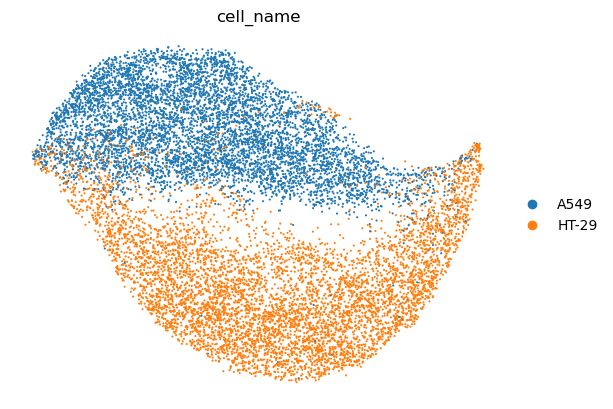

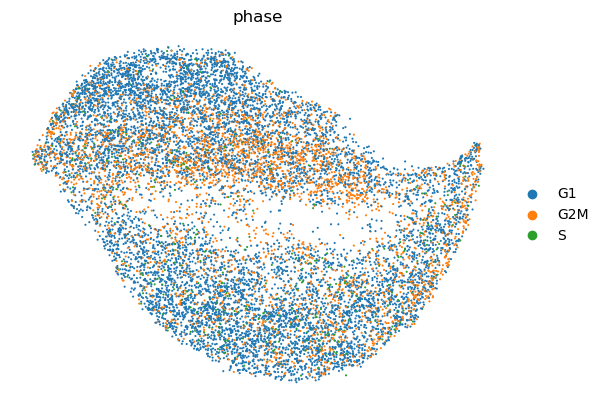

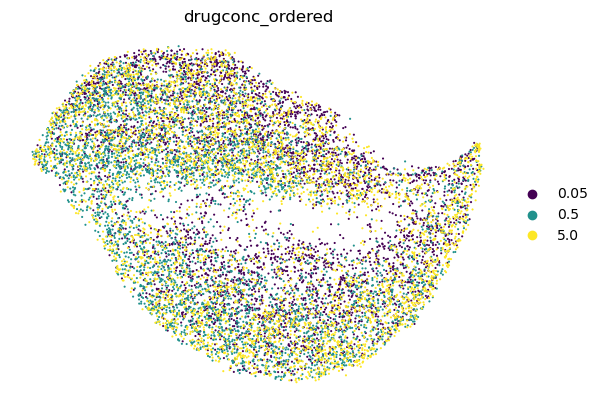

In [12]:
sc.pl.umap(
    adata,
    color=["cell_name"],
    frameon=False,
)

sc.pl.umap(
    adata,
    color=["phase"],
    ncols=2,
    frameon=False,
)

sc.pl.umap(
    adata,
    color=[ "drugconc_ordered"],
    ncols=2,
    frameon=False,
    palette="viridis"
)



In [12]:
SCVI_LATENT_KEY = "X_scVI"

latent = model.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(12894, 10)

In [13]:
import os

# Create the 'models' folder if it doesn't exist
os.makedirs("models", exist_ok=True)

# Define full path to save the model
model_dir = os.path.join("models", "scvi_model_400_Dapagliflozin")

# Save the model
model.save(model_dir, overwrite=True)

In [65]:
from scvi.model import SCVI
model_dir = os.path.join("models", "scvi_model_400_Dapagliflozin")

model_loaded = SCVI.load(model_dir,adata = adata)

INFO     File models/scvi_model_400_Dapagliflozin/model.pt already downloaded   


/Users/piamozdzanowski/anaconda3/envs/spring_2025/lib/python3.12/site-packages/scvi/model/base/_base_model.py:694: UserWarning: `accelerator` has been automatically set to `cpu` although 'mps' exists. If you wish to run on mps backend, use explicitly accelerator=='mps' in train function.In future releases it will become default for mps supported machines.
  _, _, device = parse_device_args(


In [66]:
recon = model.get_reconstruction_error()
print("Reconstruction Error:", recon)

Reconstruction Error: {'reconstruction_loss': tensor(4649.9258)}


In [14]:
print(adata.obs["drugconc"].unique())
ordered_conc = [0.05,0.5,5]
adata.obs["drugconc_ordered"] = pd.Categorical(
    adata.obs["drugconc"],
    categories=ordered_conc,
    ordered=True
)
print(adata.obs["drugconc_ordered"].unique())

[0.05 0.5  5.  ]
[0.05, 0.50, 5.00]
Categories (3, float64): [0.05 < 0.50 < 5.00]


In [69]:
SCVI_LATENT_KEY = "X_scVI"

latent = model_loaded.get_latent_representation()
adata.obsm[SCVI_LATENT_KEY] = latent
latent.shape

(12894, 10)

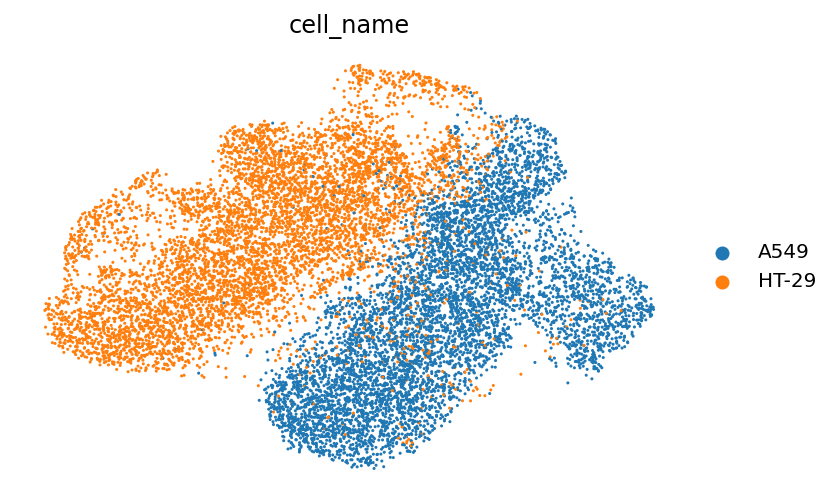

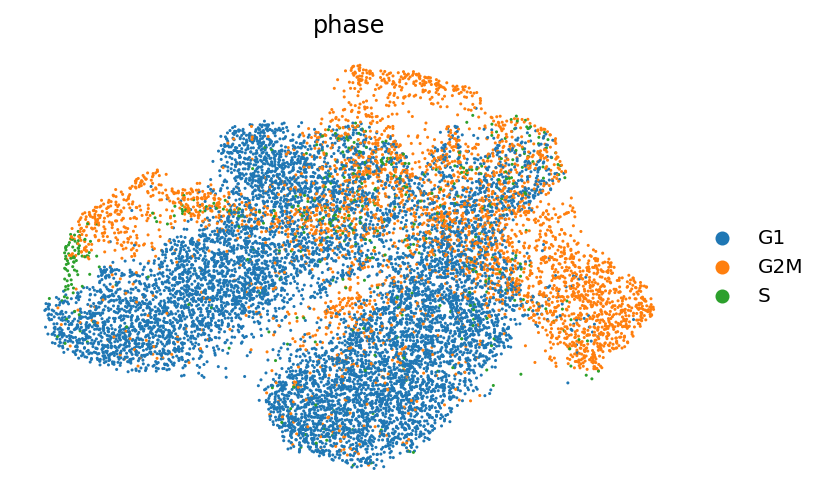

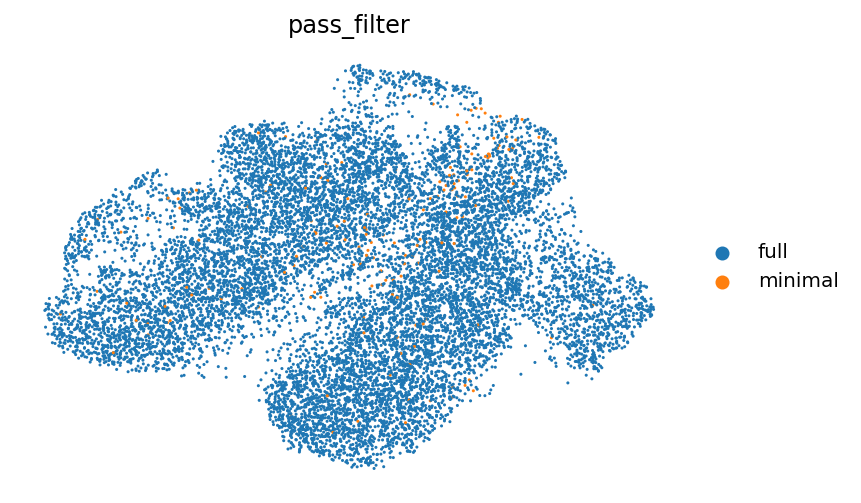

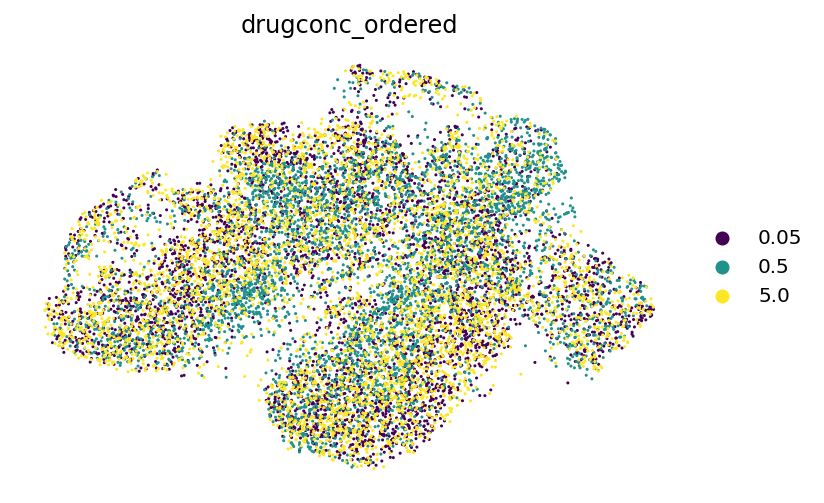

In [21]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY)
sc.tl.umap(adata, min_dist=0.5)

sc.pl.umap(
    adata,
    color=["cell_name"],
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["phase"],
    frameon=False,
)

sc.pl.umap(
    adata,
    color=["pass_filter"],
    frameon=False,
)

sc.pl.umap(
    adata,
    color=["drugconc_ordered"],
    frameon=False,
    palette="viridis"
)

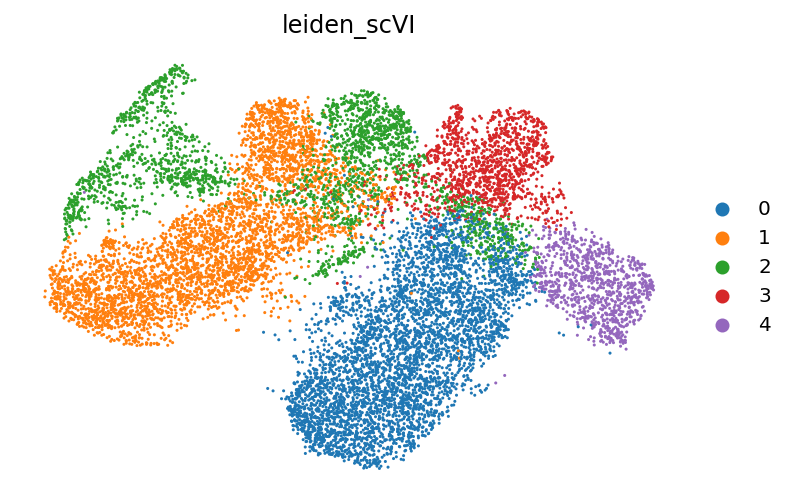

In [19]:
# neighbors were already computed using scVI
SCVI_CLUSTERS_KEY = "leiden_scVI"
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.2)
sc.pl.umap(
    adata,
    color=[SCVI_CLUSTERS_KEY],
    frameon=False,
)

In [41]:
import scanpy as sc
import scvi
import numpy as np
import pandas as pd

# Step 1: Get clusters from scVI latent space
SCVI_CLUSTERS_KEY = "leiden_scVI"

# Assuming neighbors were computed from scVI latent representation
sc.tl.leiden(adata, key_added=SCVI_CLUSTERS_KEY, resolution=0.3)

de_df = model.differential_expression(groupby=SCVI_CLUSTERS_KEY, mode="change")

# Step 3: Extract top 3 marker genes per cluster
markers = {}
clusters = adata.obs[SCVI_CLUSTERS_KEY].cat.categories

for cluster in clusters:
    cid = f"{cluster} vs Rest"
    df = de_df[de_df.comparison == cid]
    df = df[df.lfc_mean > 1]
    df = df[df.bayes_factor > 3]
    df = df[df.non_zeros_proportion1 > 0.5]
    markers[cluster] = df.sort_values("bayes_factor", ascending=False).index[:5].tolist()



DE...:   0%|          | 0/6 [00:00<?, ?it/s]

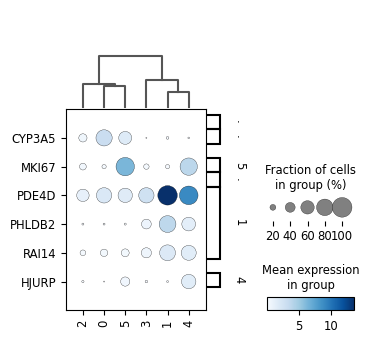

In [42]:
# Step 4: Make a dotplot grouped by cluster
sc.tl.dendrogram(adata, groupby=SCVI_CLUSTERS_KEY, use_rep="X_scVI")

sc.pl.dotplot(
    adata,
    markers,
    groupby=SCVI_CLUSTERS_KEY,
    dendrogram=True,
    color_map="Blues",
    swap_axes=True
)
